In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torch.utils.data import Subset, TensorDataset, DataLoader
from random import shuffle
from tqdm import tqdm
from copy import deepcopy
import sys
from thop import profile

In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Arguments

In [3]:
args = {
    'lr': 1e-3, 
    'lr_G': 1e-3,
    'lr_D': 1e-3,
    'lr_VAE': 1e-3,
    'epochs_VAE': 40,
    'bs': 128,
    'epochs': 5, 
    'epochs_GAN': 100,
    'num_tasks': 5,
    'dataset': "MNIST",
    'num_classes': 10, 
    'in_size': 28,
    'n_channels': 1,
    'hidden_size': 50,
    'hidden_size_GAN': 100,
    'device' : device,
    }

### Data

In [4]:

def get_dataset(dataroot, dataset):
    if dataset == 'MNIST':
        mean, std = (0.5), (0.5)
    elif dataset == 'FASHION-MNIST':
        raise NotImplementedError

    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize(mean=mean, std=std)
        ])
    
    train_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=True,
        download=True,
        transform=transform,
    )

    val_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=False,
        download=True,
        transform=transform
    )
    train_dataset
    val_dataset
    
    return train_dataset, val_dataset


def split_dataset(dataset, tasks_split):
    split_dataset = {}
    for e, current_classes in tasks_split.items():
        task_indices = np.isin(np.array(dataset.targets), current_classes)
        split_dataset[e] = Subset(dataset, np.where(task_indices)[0])
    return split_dataset

### Metrics & plotting

In [18]:
def dict2array(acc):
    num_tasks = len(acc)
    first_task = list(acc.keys())[0]
    sequence_length = len(acc[first_task]) if isinstance(acc[first_task], list) else num_tasks
    acc_array = np.zeros((num_tasks, sequence_length))
    for task, val in acc.items():
        acc_array[int(task), :] = val
    return acc_array


def plot_accuracy_matrix(array):
    num_tasks = array.shape[1]
    array = np.round(array, 2)
    fig, ax = plt.subplots()
    ax.imshow(array, vmin=np.min(array), vmax=np.max(array))
    for i in range(len(array)):
        for j in range(array.shape[1]):
            ax.text(j,i, array[i,j], va='center', ha='center', c='w', fontsize=15)
    ax.set_yticks(np.arange(num_tasks))
    ax.set_ylabel('Number of tasks')
    ax.set_xticks(np.arange(num_tasks))
    ax.set_xlabel('Tasks finished')
    ax.set_title(f"ACC: {np.mean(array[:, -1]):.3f} -- std {np.std(np.mean(array[:, -1])):.3f}")
    plt.show()


def plot_acc_over_time(array):
    fig, ax = plt.subplots()
    for e, acc in enumerate(array):
        ax.plot(acc, label=e)
    plt.legend()
    plt.show()


def compute_average_accuracy(array):
    num_tasks = len(array)
    avg_acc = np.sum(array[:, -1], axis=0)/num_tasks
    return avg_acc


def compute_backward_transfer(array):
    num_tasks = len(array)
    diag = np.diag(array)[:-1] # Note, we do not compute backward transfer for the last task!
    end_acc = array[:-1, -1]
    bwt = np.sum(end_acc - diag)/(num_tasks - 1)
    return bwt


def compute_forward_transfer(array, b):
    num_tasks = len(array)
    sub_diag = np.diag(array, k=-1) # Note, we do not compute forward transfer for the first task!
    fwt = np.sum(sub_diag - b[1:])/(num_tasks - 1)
    return fwt

def compute_model_size_eff(array):
    num_tasks = len(array)
    first_task_memory = array[0]
    memory_ratios_sum = np.sum(first_task_memory/array)

    if memory_ratios_sum/num_tasks > 1:
        return 1
    else:
        return memory_ratios_sum/num_tasks

def compute_samples_storage_eff(array, memory_bound):
    num_tasks = len(array)
    memory_ratios_sum = np.sum(array)/memory_bound

    if memory_ratios_sum/num_tasks > 1:
        return 0 
    else:
        return 1-memory_ratios_sum/num_tasks

### GAN buffer

In [6]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.5)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.5)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.5)
        return torch.sigmoid(self.fc4(x))

In [7]:
class GAN_buffer:
    def __init__(self, sample_size, args):

        self.device = args['device']

        self.sample_size = sample_size

        self._loss_history = {'D': [], 'G': []}
        # loss
        self.criterion = nn.BCELoss()

        # optimizer
        self.lr_G = args['lr_G']
        self.lr_D = args['lr_D']

        self.bs = args['bs']
        self.z_dim = args['hidden_size_GAN']
        self.data_dim = args['in_size']**2 * args['n_channels']
        self.n_epochs = args['epochs_GAN']


        self.G = Generator(g_input_dim = self.z_dim, g_output_dim = self.data_dim).to(device)
        self.D = Discriminator(d_input_dim = self.data_dim).to(device)

        self.G_optimizer = optim.Adam(self.G.parameters(), lr = self.lr_G)
        self.D_optimizer = optim.Adam(self.D.parameters(), lr = self.lr_D)

    def learn_from_loader(self, loader):
        self.D.train()
        self.G.train()
        G_losses = []
        D_losses = []

        for epoch in range(self.n_epochs):
            D_tot_loss = 0
            G_tot_loss = 0
            for batch_idx, (x, _) in enumerate(loader):
                D_loss = self._D_train(x)
                G_loss = self._G_train()
                D_tot_loss += D_loss
                G_tot_loss += G_loss
            
            D_tot_loss /= len(loader)
            G_tot_loss /= len(loader)
            D_losses.append(D_tot_loss)
            G_losses.append(G_tot_loss)
            print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
                 (epoch), self.n_epochs, D_tot_loss, G_tot_loss))

        self._loss_history['D'].append(D_losses)
        self._loss_history['G'].append(G_losses)
        return None

    def get_data(self):
        self.G.eval()
        z = torch.randn(self.sample_size, self.z_dim).to(device)
        x = self.G(z).view(-1, 1, 28, 28)
        return x.detach().cpu()
    
    def _D_train(self, x):
        #=======================Train the discriminator=======================#
        D = self.D
        G = self.G

        criterion = self.criterion
        data_dim = self.data_dim
        bs = self.bs
        z_dim = self.z_dim
        D_optimizer = self.D_optimizer

        num_data = x.shape[0]

    
        D.zero_grad()

        # train discriminator on real
        x_real, y_real = x.view(-1, data_dim), torch.ones(num_data, 1)
        x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

        D_output = D(x_real)

        D_real_loss = criterion(D_output, y_real)
        D_real_score = D_output

        # train discriminator on facke
        z = Variable(torch.randn(bs, z_dim).to(device))
        x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

        D_output = D(x_fake)
        D_fake_loss = criterion(D_output, y_fake)
        D_fake_score = D_output

        # gradient backprop & optimize ONLY D's parameters
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()


        return  D_loss.data.item()
    
    def _G_train(self):
        #=======================Train the generator=======================#
        D = self.D
        G = self.G

        criterion = self.criterion
        bs = self.bs
        z_dim = self.z_dim
        G_optimizer = self.G_optimizer
        
        G.zero_grad()

        z = Variable(torch.randn(bs, z_dim).to(device))
        y = Variable(torch.ones(bs, 1).to(device))

        G_output = G(z)
        D_output = D(G_output)
        G_loss = criterion(D_output, y)

        # gradient backprop & optimize ONLY G's parameters
        G_loss.backward()
        G_optimizer.step()

        return G_loss.data.item()

### VAE buffer

In [8]:
class VAE(nn.Module):
    def __init__(self, mnist_dim=784):
        super(VAE, self).__init__()

        self.mnist_dim = mnist_dim

        self.fc1 = nn.Linear(mnist_dim, 128) #Encoder
        self.fc21 = nn.Linear(128, 8) #mu
        self.fc22 = nn.Linear(128, 8) #sigma

        self.fc3 = nn.Linear(8, 128) #Decoder
        self.fc4 = nn.Linear(128, mnist_dim)
        
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std
    
    
    def sampling(self, mu, std): # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu)) # Using two samples to compute expectation over z

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h)) 
    
    def forward(self, x):
        mu, std = self.encoder(x.view(-1, self.mnist_dim))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std

In [9]:
class VAE_buffer:
    def __init__(self, sample_size, args):

        self.device = args['device']

        self.sample_size = sample_size

        self._loss_history = []
        # loss
        self.criterion = nn.BCELoss()

        # optimizer
        self.lr_VAE = args['lr_VAE']

        self.data_dim = args['in_size']**2 * args['n_channels']
        self.n_epochs = args['epochs_VAE']

    
    def loss_function(self, y, x, mu, std): 
        ERR = F.binary_cross_entropy(y, x.view(-1, self.data_dim), reduction='sum')
        KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
        return ERR + KLD, -ERR, -KLD

    def learn_from_loader(self, loader):
        self.VAE = VAE(mnist_dim = self.data_dim).to(device)

        self.optimizer = optim.Adam(self.VAE.parameters(), lr = self.lr_VAE)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'max', factor=0.5, 
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001, verbose=True)
        
        err_l, kld_l = [], []
        for epoch in range(1, self.n_epochs):

            train_loss = 0
            for batch_idx, (data, _) in enumerate(loader):
                self.VAE.train()
                bsize = data.shape[0]
                recon_batch, mu, std = self.VAE(data)
                loss, err, kld = self.loss_function(recon_batch, data, mu, std)
                loss.backward()
                train_loss += err.item() + kld.item()
                self.optimizer.step()
                self.optimizer.zero_grad()
                err_l.append(err.item()/bsize)
                kld_l.append(kld.item()/bsize)

            self.scheduler.step(train_loss / len(loader.dataset))
            
            print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(loader.dataset)))

    def get_data(self):
        self.VAE.eval()
        z = np.random.normal(0,1, (self.sample_size, 8))
        z = z.astype(np.float32)
        z = torch.from_numpy(z)
        #x= x.cuda()
        recon = self.VAE.decoder(z)
        b = recon.view(-1, 1, 28, 28)
        return b.detach().cpu()

## Agent and experiments with VAE buffer

In [51]:

class Agent:
    def __init__(self, args, train_datasets, val_datasets):
        self.args = args
        model = MLP(self.args)

        self.model = model.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args['lr'])
        self.criterion = torch.nn.CrossEntropyLoss()
        self.reset_metrics()
        self.train_datasets = train_datasets
        self.val_datasets = val_datasets
        
        self.buffer = VAE_buffer(sample_size=10000, args=args) #GAN_buffer(sample_size=1000, args=args)
    
    def reset_metrics(self):
        self.acc = {key: [] for key in self.args['task_names']}
        self.acc_end = {key: [] for key in self.args['task_names']}
        self.model_memory = {key: None for key in self.args['task_names']}

    def train(self):
        for task, new_task_data in self.train_datasets.items():
            """
              Put the data loader to the buffer (use store_data method).
              Retrieve previously stored data and create "greedy_loader" using
              TensorDataset class.
            """
            print(f"Task {task} ---- ")
            loader = DataLoader(new_task_data, batch_size=self.args['bs'], )
            samples, targets = torch.Tensor([]), torch.Tensor([])
            for sample, target in loader:
                samples = torch.cat((samples, sample))
                targets = torch.cat((targets, target))
            targets = targets.long()
            print('num new samples: ', len(samples))
            
            if int(task) > 0:
                self.model.eval()
                old_task_samples = self.buffer.get_data()
                old_task_targets = self.model(old_task_samples.to(device)).argmax(dim=1).cpu().long()

                complete_samples = torch.cat((old_task_samples, samples))
                complete_targets = torch.cat((old_task_targets, targets))

                print('num generated samples: ', len(old_task_samples))

                complete_data = TensorDataset(complete_samples.clone(), complete_targets.clone())
                loader = DataLoader(complete_data, batch_size=self.args['bs'], shuffle=True)

                self.buffer.learn_from_loader(loader)

                #complete_data = TensorDataset(complete_samples.clone(), complete_targets.clone())
                #loader = DataLoader(complete_data, batch_size=self.args['bs'], shuffle=True)
            else:
                self.buffer.learn_from_loader(loader)
            
            for epoch in range(self.args['epochs']):
                self.model.train()
                epoch_loss = 0
                total = 0
                correct = 0
                for e, (X, y) in tqdm(enumerate(loader)):
                    X, y = X.to(device), y.to(device)
                    output = self.model(X)
                    loss = self.criterion(output, y)
                    self.optimizer.zero_grad()
                    loss.backward()  
                    self.optimizer.step()

                    epoch_loss += loss.item()
                    correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y).item()
                    total += len(X)
                    if e % 50 == 0:
                        self.validate()
                print(f"Epoch {epoch}: Loss {epoch_loss/(e+1):.3f} Acc: {correct/total:.3f}")
            self.validate(end_of_epoch=True)

            param_size = 0
            for param in self.model.parameters():
                param_size += param.nelement() * param.element_size()
            for param in self.buffer.VAE.parameters():
                param_size += param.nelement() * param.element_size()
            buffer_size = 0
            for buffer in self.model.buffers():
                buffer_size += buffer.nelement() * buffer.element_size()
            for buffer in self.buffer.VAE.buffers():
                buffer_size += buffer.nelement() * buffer.element_size()

            self.model_memory[task] = (param_size + buffer_size) / 1024**2



    @torch.no_grad()
    def validate(self, end_of_epoch=False):
        self.model.eval()
        for task, data in self.val_datasets.items():
            loader = torch.utils.data.DataLoader(data, batch_size=args['bs'], shuffle=True)
            correct, total = 0, 0
            for e, (X, y) in enumerate(loader):
                X, y = X.to(device), y.to(device)
                output = self.model(X)
                correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y).item()
                total += len(X)
            self.acc[task].append(correct/total)
            if end_of_epoch:
                self.acc_end[task].append(correct/total)
        self.model.train()


class MLP(torch.nn.Module):
    def __init__(self, args):
        super().__init__()
        hidden_size = args['hidden_size']
        self.fc1 = torch.nn.Linear(args['in_size']**2 * args['n_channels'], hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, args['num_classes'])

    def forward(self, input):
        x_mlp = input.flatten(start_dim=1)
        x_mlp = torch.nn.functional.relu(self.fc1(x_mlp))
        x_mlp = torch.nn.functional.relu(self.fc2(x_mlp))
        x_mlp = torch.nn.functional.relu(self.fc3(x_mlp))
        x_mlp = self.fc4(x_mlp)
        return x_mlp


In [52]:
classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
print(class_split)
args['task_names'] = list(class_split.keys())

{'0': [5, 3], '1': [4, 7], '2': [0, 2], '3': [8, 9], '4': [6, 1]}


Task 0 ---- 
num new samples:  11552
====> Epoch: 1 Average loss: -282.3473
====> Epoch: 2 Average loss: -190.6618
====> Epoch: 3 Average loss: -171.2341
====> Epoch: 4 Average loss: -164.1604
====> Epoch: 5 Average loss: -155.1762
====> Epoch: 6 Average loss: -151.0613
====> Epoch: 7 Average loss: -147.6879
====> Epoch: 8 Average loss: -144.4068
====> Epoch: 9 Average loss: -141.7613
====> Epoch: 10 Average loss: -139.9239
====> Epoch: 11 Average loss: -138.3556
====> Epoch: 12 Average loss: -137.1535
====> Epoch: 13 Average loss: -135.8862
====> Epoch: 14 Average loss: -134.7783
====> Epoch: 15 Average loss: -133.6495
====> Epoch: 16 Average loss: -132.6579
====> Epoch: 17 Average loss: -131.7175
====> Epoch: 18 Average loss: -130.8836
====> Epoch: 19 Average loss: -130.1336
====> Epoch: 20 Average loss: -129.4304
====> Epoch: 21 Average loss: -128.7150
====> Epoch: 22 Average loss: -128.1156
====> Epoch: 23 Average loss: -127.5504
====> Epoch: 24 Average loss: -126.9368
====> Epoch:

91it [00:01, 80.85it/s]


Epoch 0: Loss 0.740 Acc: 0.757


91it [00:01, 84.58it/s] 


Epoch 1: Loss 0.123 Acc: 0.952


91it [00:01, 79.00it/s]


Epoch 2: Loss 0.100 Acc: 0.963


91it [00:01, 76.40it/s]


Epoch 3: Loss 0.085 Acc: 0.970


91it [00:01, 74.37it/s]


Epoch 4: Loss 0.074 Acc: 0.974
Task 1 ---- 
num new samples:  12107
num generated samples:  10000
====> Epoch: 1 Average loss: -249.7986
====> Epoch: 2 Average loss: -186.9616
====> Epoch: 3 Average loss: -175.1770
====> Epoch: 4 Average loss: -167.4935
====> Epoch: 5 Average loss: -162.3097
====> Epoch: 6 Average loss: -160.9928
====> Epoch: 7 Average loss: -162.3646
====> Epoch: 8 Average loss: -160.2837
====> Epoch: 9 Average loss: -156.1799
====> Epoch: 10 Average loss: -155.2241
====> Epoch: 11 Average loss: -152.0560
====> Epoch: 12 Average loss: -151.9266
====> Epoch: 13 Average loss: -152.1537
====> Epoch: 14 Average loss: -152.2895
====> Epoch: 15 Average loss: -149.2291
====> Epoch: 16 Average loss: -145.1316
====> Epoch: 17 Average loss: -143.4393
====> Epoch: 18 Average loss: -141.7458
====> Epoch: 19 Average loss: -140.6146
====> Epoch: 20 Average loss: -139.1753
====> Epoch: 21 Average loss: -138.2697
====> Epoch: 22 Average loss: -137.6775
====> Epoch: 23 Average loss: -

173it [00:01, 112.91it/s]


Epoch 0: Loss 0.537 Acc: 0.867


173it [00:01, 113.70it/s]


Epoch 1: Loss 0.069 Acc: 0.979


173it [00:01, 114.07it/s]


Epoch 2: Loss 0.052 Acc: 0.984


173it [00:01, 112.10it/s]


Epoch 3: Loss 0.041 Acc: 0.987


173it [00:01, 112.99it/s]


Epoch 4: Loss 0.038 Acc: 0.987
Task 2 ---- 
num new samples:  11881
num generated samples:  10000
====> Epoch: 1 Average loss: -259.5811
====> Epoch: 2 Average loss: -191.0007
====> Epoch: 3 Average loss: -173.3201
====> Epoch: 4 Average loss: -165.3610
====> Epoch: 5 Average loss: -174.8705
====> Epoch: 6 Average loss: -167.9555
====> Epoch: 7 Average loss: -159.8135
====> Epoch: 8 Average loss: -156.3735
====> Epoch: 9 Average loss: -154.2768
====> Epoch: 10 Average loss: -151.1891
====> Epoch: 11 Average loss: -151.0481
====> Epoch: 12 Average loss: -149.3216
====> Epoch: 13 Average loss: -148.7198
====> Epoch: 14 Average loss: -146.1561
====> Epoch: 15 Average loss: -144.9036
====> Epoch: 16 Average loss: -144.6834
====> Epoch: 17 Average loss: -143.3594
====> Epoch: 18 Average loss: -142.4647
====> Epoch: 19 Average loss: -141.6548
====> Epoch: 20 Average loss: -140.9814
====> Epoch: 21 Average loss: -140.4292
====> Epoch: 22 Average loss: -139.8355
====> Epoch: 23 Average loss: -

171it [00:01, 107.60it/s]


Epoch 0: Loss 1.099 Acc: 0.716


171it [00:01, 112.51it/s]


Epoch 1: Loss 0.197 Acc: 0.936


171it [00:01, 112.03it/s]


Epoch 2: Loss 0.140 Acc: 0.955


171it [00:01, 108.05it/s]


Epoch 3: Loss 0.112 Acc: 0.964


171it [00:01, 110.88it/s]


Epoch 4: Loss 0.094 Acc: 0.969
Task 3 ---- 
num new samples:  11800
num generated samples:  10000
====> Epoch: 1 Average loss: -248.5493
====> Epoch: 2 Average loss: -174.9029
====> Epoch: 3 Average loss: -161.8172
====> Epoch: 4 Average loss: -156.5396
====> Epoch: 5 Average loss: -156.7609
====> Epoch: 6 Average loss: -155.4858
====> Epoch: 7 Average loss: -158.7995
====> Epoch: 8 Average loss: -150.8779
====> Epoch: 9 Average loss: -148.6574
====> Epoch: 10 Average loss: -147.0082
====> Epoch: 11 Average loss: -149.1924
====> Epoch: 12 Average loss: -144.5533
====> Epoch: 13 Average loss: -142.7605
====> Epoch: 14 Average loss: -141.7540
====> Epoch: 15 Average loss: -142.2508
====> Epoch: 16 Average loss: -140.3203
====> Epoch: 17 Average loss: -139.6261
====> Epoch: 18 Average loss: -138.9723
====> Epoch: 19 Average loss: -138.4205
====> Epoch: 20 Average loss: -137.9626
====> Epoch: 21 Average loss: -137.4672
====> Epoch: 22 Average loss: -137.0690
====> Epoch: 23 Average loss: -

171it [00:01, 97.56it/s] 


Epoch 0: Loss 1.260 Acc: 0.677


171it [00:01, 103.46it/s]


Epoch 1: Loss 0.370 Acc: 0.877


171it [00:02, 85.47it/s]


Epoch 2: Loss 0.280 Acc: 0.907


171it [00:01, 104.42it/s]


Epoch 3: Loss 0.229 Acc: 0.922


171it [00:01, 107.87it/s]


Epoch 4: Loss 0.200 Acc: 0.932
Task 4 ---- 
num new samples:  12660
num generated samples:  10000
====> Epoch: 1 Average loss: -226.6715
====> Epoch: 2 Average loss: -153.4256
====> Epoch: 3 Average loss: -141.2889
====> Epoch: 4 Average loss: -135.3871
====> Epoch: 5 Average loss: -130.4597
====> Epoch: 6 Average loss: -128.2648
====> Epoch: 7 Average loss: -126.5895
====> Epoch: 8 Average loss: -125.8526
====> Epoch: 9 Average loss: -124.2064
====> Epoch: 10 Average loss: -123.2978
====> Epoch: 11 Average loss: -122.7152
====> Epoch: 12 Average loss: -122.5600
====> Epoch: 13 Average loss: -119.5086
====> Epoch: 14 Average loss: -123.1866
====> Epoch: 15 Average loss: -119.3445
====> Epoch: 16 Average loss: -117.0177
====> Epoch: 17 Average loss: -116.0293
====> Epoch: 18 Average loss: -115.2155
====> Epoch: 19 Average loss: -114.5507
====> Epoch: 20 Average loss: -117.2684
====> Epoch: 21 Average loss: -116.9241
====> Epoch: 22 Average loss: -114.1970
====> Epoch: 23 Average loss: -

178it [00:01, 116.02it/s]


Epoch 0: Loss 1.143 Acc: 0.717


178it [00:01, 117.06it/s]


Epoch 1: Loss 0.269 Acc: 0.914


178it [00:01, 116.97it/s]


Epoch 2: Loss 0.197 Acc: 0.932


178it [00:01, 116.25it/s]


Epoch 3: Loss 0.159 Acc: 0.944


178it [00:02, 84.47it/s]


Epoch 4: Loss 0.137 Acc: 0.951


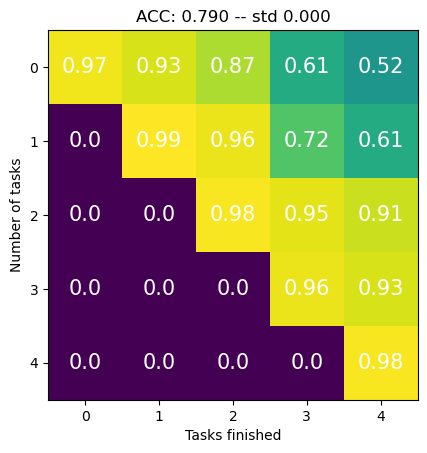

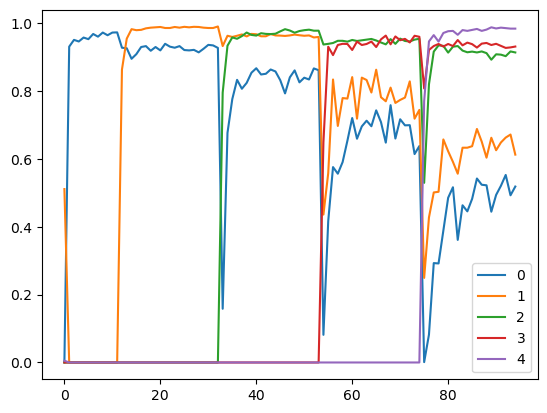

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
The average accuracy at the end of sequence is: 0.792
BWT:'-0.231'
FWT:'-0.127'
Model size efficiency: 1.000
Model (forward) MACs: 44700.0
Buffer (forward) MACs: 203776.0


In [53]:

train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)
agent = Agent(args, train_tasks, val_tasks)

agent.validate()
random_model_acc = [i[0] for i in agent.acc.values()]

agent.reset_metrics()
agent.train()

model_memories = np.array([agent.model_memory[task] for task in agent.model_memory])


acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)

acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

ms_eff = compute_model_size_eff(model_memories)

model_macs, _  = profile(agent.model, inputs=(torch.randn(1, 28, 28).to(device),))
buffer_macs, _ = profile(agent.buffer.VAE, inputs=(torch.randn(1, 28, 28).to(device),))


print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")

print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")

print(f"Model size efficiency: {ms_eff:.3f}")

print(f"Model (forward) MACs: {model_macs}")
print(f"Buffer (forward) MACs: {buffer_macs}")

## Agent and experiment with greedy buffer

In [19]:
class GreedyBuffer:
    def __init__(self, samples_per_class):
        self.samples_per_class = samples_per_class
        self.samples = torch.Tensor([])
        self.targets = torch.Tensor([])

    def store_data(self, loader):
        samples, targets = torch.Tensor([]), torch.Tensor([])
        for sample, target in loader:
            samples = torch.cat((samples, sample))
            targets = torch.cat((targets, target))
        
        for label in torch.unique(targets):
            greedy_idx = torch.where(targets == label)[0][:self.samples_per_class]
            self.samples = torch.cat((self.samples, samples[greedy_idx]))
            self.targets = torch.cat((self.targets, targets[greedy_idx]))

    def get_data(self):
        return self.samples, self.targets.to(torch.int64)

    def __len__(self):
        assert len(self.samples) == len(self.targets), f"Incosistent lengths of data tensor: {self.samples.shape}, target tensor: {self.targets.shape}!"
        return len(self.samples)

In [44]:

class Agent:
    def __init__(self, args, train_datasets, val_datasets):
        self.args = args
        model = MLP(self.args)

        self.model = model.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args['lr'])
        self.criterion = torch.nn.CrossEntropyLoss()
        self.reset_metrics()
        self.train_datasets = train_datasets

        self.val_datasets = val_datasets
        
        self.buffer = GreedyBuffer(samples_per_class = 300) 
    
    def reset_metrics(self):
        self.acc = {key: [] for key in self.args['task_names']}
        self.acc_end = {key: [] for key in self.args['task_names']}
        self.model_memory = {key: None for key in self.args['task_names']}
        self.loader_memory = {key: None for key in self.args['task_names']}
        


    def train(self):
        for task, data in self.train_datasets.items():
            loader = DataLoader(data, batch_size=self.args['bs'])
            """
              Put the data loader to the buffer (use store_data method).
              Retrieve previously stored data and create "greedy_loader" using
              TensorDataset class.
            """
             
            self.buffer.store_data(loader)
            print(f"Task {task} -- buffer stores {len(self.buffer)} samples")
            samples, targets = self.buffer.get_data()
            greedy_dataset = TensorDataset(samples, targets)
            greedy_loader = DataLoader(greedy_dataset, batch_size=self.args['bs'], shuffle=True)

            self.loader_memory[task] = samples.nelement() * samples.element_size() + targets.nelement() * targets.element_size()
            
            for epoch in range(self.args['epochs']):
                epoch_loss = 0
                total = 0
                correct = 0
                for e, (X, y) in enumerate(greedy_loader):
                    if torch.cuda.is_available():
                        X, y = X.cuda(), y.cuda()
                    output = self.model(X)
                    loss = self.criterion(output, y)
                    self.optimizer.zero_grad()
                    loss.backward() 
                    self.optimizer.step()
                    epoch_loss += loss.item()
                    correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y)
                    total += len(X)
                    if e % 50 == 0:
                        self.validate()
                print(f"Epoch {epoch}: Loss {epoch_loss/(e+1):.3f} Acc: {correct/total:.3f}")
            self.validate(end_of_epoch=True)

            param_size = 0
            for param in self.model.parameters():
                param_size += param.nelement() * param.element_size()
            buffer_size = 0
            for buffer in self.model.buffers():
                buffer_size += buffer.nelement() * buffer.element_size()

            self.model_memory[task] = (param_size + buffer_size) / 1024**2



    @torch.no_grad()
    def validate(self, end_of_epoch=False):
        self.model.eval()
        for task, data in self.val_datasets.items():
            loader = torch.utils.data.DataLoader(data, batch_size=args['bs'], shuffle=True)
            correct, total = 0, 0
            for e, (X, y) in enumerate(loader):
                X, y = X.to(device), y.to(device)
                output = self.model(X)
                correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y).item()
                total += len(X)
            self.acc[task].append(correct/total)
            if end_of_epoch:
                self.acc_end[task].append(correct/total)
        self.model.train()


class MLP(torch.nn.Module):
    def __init__(self, args):
        super().__init__()
        hidden_size = args['hidden_size']
        self.fc1 = torch.nn.Linear(args['in_size']**2 * args['n_channels'], hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, args['num_classes'])

    def forward(self, input):
        x_mlp = input.flatten(start_dim=1)
        x_mlp = torch.nn.functional.relu(self.fc1(x_mlp))
        x_mlp = torch.nn.functional.relu(self.fc2(x_mlp))
        x_mlp = torch.nn.functional.relu(self.fc3(x_mlp))
        x_mlp = self.fc4(x_mlp)
        return x_mlp


In [45]:
classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
print(class_split)
args['task_names'] = list(class_split.keys())

{'0': [6, 9], '1': [8, 4], '2': [5, 1], '3': [2, 7], '4': [0, 3]}


Task 0 -- buffer stores 600 samples
Epoch 0: Loss 2.189 Acc: 0.500
Epoch 1: Loss 1.933 Acc: 0.503
Epoch 2: Loss 1.464 Acc: 0.507
Epoch 3: Loss 0.885 Acc: 0.555
Epoch 4: Loss 0.439 Acc: 0.947
Task 1 -- buffer stores 1200 samples
Epoch 0: Loss 2.610 Acc: 0.497
Epoch 1: Loss 1.444 Acc: 0.496
Epoch 2: Loss 1.169 Acc: 0.616
Epoch 3: Loss 0.910 Acc: 0.649
Epoch 4: Loss 0.756 Acc: 0.713
Task 2 -- buffer stores 1800 samples
Epoch 0: Loss 2.015 Acc: 0.486
Epoch 1: Loss 1.410 Acc: 0.519
Epoch 2: Loss 1.216 Acc: 0.618
Epoch 3: Loss 0.926 Acc: 0.757
Epoch 4: Loss 0.687 Acc: 0.801
Task 3 -- buffer stores 2400 samples
Epoch 0: Loss 2.116 Acc: 0.640
Epoch 1: Loss 1.244 Acc: 0.637
Epoch 2: Loss 0.836 Acc: 0.749
Epoch 3: Loss 0.579 Acc: 0.832
Epoch 4: Loss 0.446 Acc: 0.869
Task 4 -- buffer stores 3000 samples
Epoch 0: Loss 1.742 Acc: 0.666
Epoch 1: Loss 0.926 Acc: 0.745
Epoch 2: Loss 0.544 Acc: 0.836
Epoch 3: Loss 0.405 Acc: 0.879
Epoch 4: Loss 0.334 Acc: 0.902


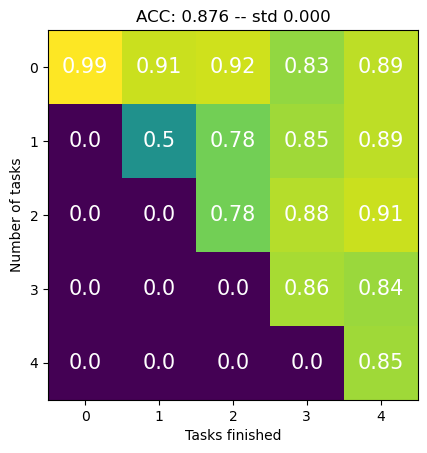

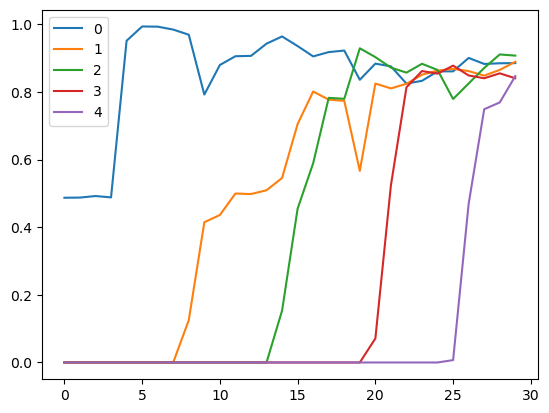

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
The average accuracy at the end of sequence is: 0.874
BWT:'0.096'
FWT:'0.000'
Model size efficiency: 1.000
Samples storage efficiency: 0.400
Model (forward) MACs: 44700.0


In [47]:

train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)
agent = Agent(args, train_tasks, val_tasks)

agent.validate()
random_model_acc = [i[0] for i in agent.acc.values()]

agent.reset_metrics()
agent.train()

model_memories = np.array([agent.model_memory[task] for task in agent.model_memory])
loader_memories = np.array([agent.loader_memory[task] for task in agent.loader_memory])
memory_bound = loader_memories[-1]

acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)

acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

ms_eff = compute_model_size_eff(model_memories)
sss_eff = compute_samples_storage_eff(loader_memories, memory_bound)

model_macs, _  = profile(agent.model, inputs=(torch.randn(1, 28, 28).to(device),))

print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")

print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")

print(f"Model size efficiency: {ms_eff:.3f}")
print(f"Samples storage efficiency: {sss_eff:.3f}")

print(f"Model (forward) MACs: {model_macs}")